## 삼성전자 주가예측

#### 라이브러리 임포트

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

#### 데이터 불러오기
#### 삼성전자 주식가격(2016.1월 ~ 2021.10월)

In [20]:
data = pd.read_csv('samsung.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,25200.0,25200.0,24100.0,24100.0,20770.699219,15346950.0
1,2016-01-05,24040.0,24360.0,23720.0,24160.0,20822.408203,10800100.0
2,2016-01-06,24160.0,24160.0,23360.0,23500.0,20253.583984,18337600.0
3,2016-01-07,23320.0,23660.0,23020.0,23260.0,20046.744141,14119400.0
4,2016-01-08,23260.0,23720.0,23260.0,23420.0,20184.636719,12888150.0


## 데이터 전처리

In [21]:
# 결측치 제거
dataset = data.dropna()

In [22]:
# High, Low값의 중간값 구하기
high_prices = dataset['High'].values
low_prices = dataset['Low'].values

mid_prices = (high_prices + low_prices) / 2

In [23]:
mid_prices

array([24650., 24040., 23760., ..., 73450., 72200., 72350.])

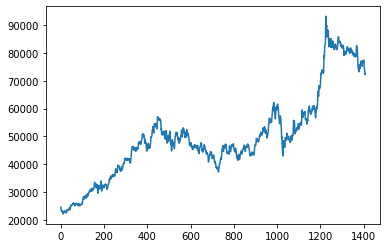

In [24]:
# 중간값 그래프로 표시
plt.plot(mid_prices)

## 50일간의 데이터를 확인하여 내일 주가 예측

In [36]:
seq_len = 50 # 최근 50일
sequence_length = seq_len + 1 # 50일로 하루를 예측

result = []

for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

### z-score 정규화
### train, test 데이터 9:1로 분리 후 numpy 배열로 바꿔주기

In [26]:
# z-score 정규화
normalized_data = []
window_mean = []
window_std = []

for window in result:
    normalized_window = [((p - np.mean(window)) / np.std(window)) for p in window]
    normalized_data.append(normalized_window)
    
    window_mean.append(np.mean(window))
    window_std.append(np.std(window))
    
result = np.array(normalized_data)

# train, test 데이터 분리
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]

# 365일(x)로 1일(y) 예측
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1221, 50, 1), (136, 50, 1))

## 모델

In [27]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 21,057
Trainable params: 21,057
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [28]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=10)

Epoch 1/10
123/123 [==============================] - 6s 22ms/step - loss: 1.0882 - val_loss: 1.0529
Epoch 2/10
123/123 [==============================] - 2s 15ms/step - loss: 0.3569 - val_loss: 0.3897
Epoch 3/10
123/123 [==============================] - 2s 16ms/step - loss: 0.1856 - val_loss: 0.2705
Epoch 4/10
123/123 [==============================] - 2s 16ms/step - loss: 0.1494 - val_loss: 0.2779
Epoch 5/10
123/123 [==============================] - 2s 15ms/step - loss: 0.1580 - val_loss: 0.3070
Epoch 6/10
123/123 [==============================] - 2s 16ms/step - loss: 0.1505 - val_loss: 0.2581
Epoch 7/10
123/123 [==============================] - 2s 16ms/step - loss: 0.1435 - val_loss: 0.2535
Epoch 8/10
123/123 [==============================] - 2s 15ms/step - loss: 0.1490 - val_loss: 0.2852
Epoch 9/10
123/123 [==============================] - 2s 16ms/step - loss: 0.1354 - val_loss: 0.2569
Epoch 10/10
123/123 [==============================] - 2s 16ms/step - loss: 0.1251 - val_lo

## 예측 및 평가

In [29]:
pred = model.predict(x_test)

In [30]:
# 모델 예측 후, 다시 값을 복원
pred_result = []
pred_y = []

for i in range(len(pred)):
    n1 = (pred[i] * window_std[i]) + window_mean[i]
    n2 = (y_test[i] * window_std[i]) + window_mean[i]
    
    pred_result.append(n1)
    pred_y.append(n2)

### 파락색은 실제값, 주황색은 예측값 그래프 표시

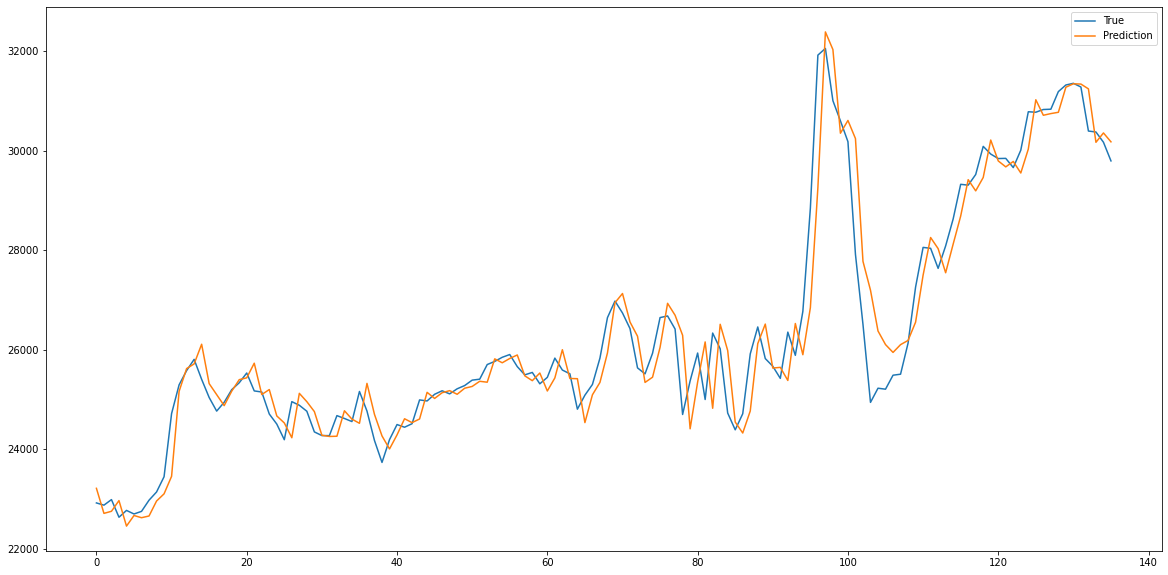

In [31]:
fig = plt.figure(facecolor='white', figsize=(20, 10))

ax = fig.add_subplot(111)
ax.plot(pred_y, label='True')
ax.plot(pred_result, label='Prediction')
ax.legend()

plt.show()


## 모델 테스트

### 지난 1년의 데이터를 가지고 테스트

In [37]:
lt = mid_prices[-365:]
len(lt)

365

In [38]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(lt) - sequence_length):
    result.append(lt[index: index + sequence_length])

In [39]:
# z-score 정규화
normalized_data = []
window_mean = []
window_std = []

for window in result:
    normalized_window = [((p - np.mean(window)) / np.std(window)) for p in window]
    normalized_data.append(normalized_window)
    window_mean.append(np.mean(window))
    window_std.append(np.std(window))

result = np.array(normalized_data)

x_test = result[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[:, -1]

x_test.shape

(314, 50, 1)

In [40]:
pred = model.predict(x_test)

In [41]:
# 복원
pred_result = []
pred_y = []
for i in range(len(pred)):
    n1 = (pred[i] * window_std[i]) + window_mean[i]
    n2 = (y_test[i] * window_std[i]) + window_mean[i]
    pred_result.append(n1)
    pred_y.append(n2)

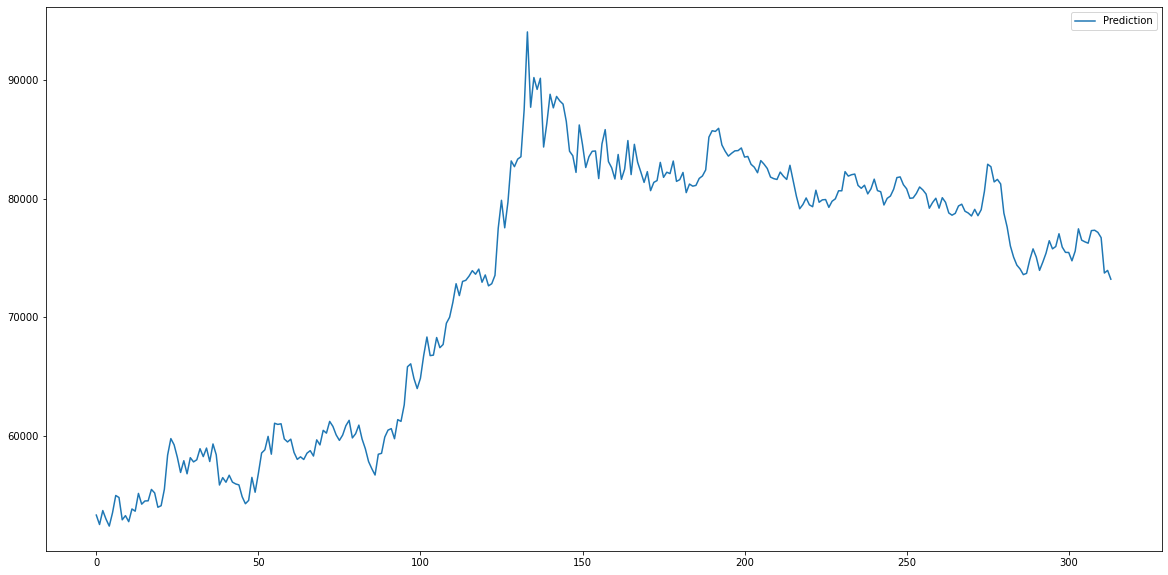

In [42]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(pred_result, label='Prediction')
ax.legend()
plt.show()

In [46]:
print('2021년 10월 3일의 주가는', '%0.2f'%float(pred_result[-3]))
print('2021년 10월 4일의 주가는', '%0.2f'%float(pred_result[-2]))
print('2021년 10월 5일의 주가는', '%0.2f'%float(pred_result[-1]))

2021년 10월 3일의 주가는 73717.42
2021년 10월 4일의 주가는 73939.23
2021년 10월 5일의 주가는 73199.02
2021년 10월 6일의 주가는 76702.80
